## Installations needed for Erda to work

In [1]:
!pip install -U pip tensorflow tensorboard mediapipe tensorflow plotly scikeras tensorrt scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 31.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 40.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 57.8 MB/s eta 0:00:00
     

In [57]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


# Used to create training and testing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Used for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
import keras
#Used for parameter tuning
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#For accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
os.getcwd()

'/home/jovyan/work/Bachelorproject/src'

# 1. Importing and Splitting Data

In [19]:
X_train = np.load('../export_data/pca_train.npy')
y_train = np.load('../export_data/y_pca_train.npy')
X_test = np.load('../export_data/pca_test.npy')
y_test = np.load('../export_data/y_pca_test.npy')

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(167, 12)
(54, 12)
(167, 9)
(54, 9)


In [63]:
X = np.append(X_train, X_test)
y = np.append(y_train, y_test)
X = np.reshape(X, (221,12,1))
y = np.reshape(y, (221,9,1))

In [64]:
X.shape
y.shape

(221, 9, 1)

In [34]:
X_train = np.reshape(X_train, (167,12,1))

In [35]:
print(X_train.shape)

(167, 12, 1)


In [6]:
for i in range (y_train.shape[1]):
    print("Number of words in " + str(i) + " category: " + str(np.count_nonzero(y_test[:,i])))

Number of words in 0 category: 5
Number of words in 1 category: 5
Number of words in 2 category: 6
Number of words in 3 category: 6
Number of words in 4 category: 6
Number of words in 5 category: 6
Number of words in 6 category: 8
Number of words in 7 category: 7
Number of words in 8 category: 5


# 2. Neural Network Implementation

### Saving Logs

In [7]:
tracing_logs = TensorBoard(os.path.join('Logs'))

### LSTM Implementation

In [39]:
def create_model(neurons):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='relu', input_shape=(12,1)))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
model = KerasClassifier(model=create_model, verbose=0)


In [40]:
# define the grid search parameters
neurons = [8, 16, 32, 64]
learn_rate = [0.001, 0.01, 0.1]
epochs = [50, 100]
param_grid = dict(model__neurons=neurons, optimizer__learning_rate=learn_rate, epochs=epochs)
search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<function create_model at 0x7fda88679160>, verbose=0),
             param_grid={'epochs': [50, 100], 'model__neurons': [8, 16, 32, 64],
                         'optimizer__learning_rate': [0.001, 0.01, 0.1]})

In [41]:
search.best_score_


0.6413547237076649

In [42]:
search.best_params_


{'epochs': 100, 'model__neurons': 64, 'optimizer__learning_rate': 0.01}

In [58]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(12,1)))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs = 100, callbacks = [tracing_logs])


Epoch 1/100
6/6 [==============================] - 1s 10ms/step - loss: 2.1480 - categorical_accuracy: 0.1557
Epoch 2/100
6/6 [==============================] - 0s 22ms/step - loss: 1.8773 - categorical_accuracy: 0.4012
Epoch 3/100
6/6 [==============================] - 0s 35ms/step - loss: 1.5250 - categorical_accuracy: 0.5150
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 1.2581 - categorical_accuracy: 0.5210
Epoch 5/100
6/6 [==============================] - 0s 36ms/step - loss: 1.0307 - categorical_accuracy: 0.7006
Epoch 6/100
6/6 [==============================] - 0s 36ms/step - loss: 0.8762 - categorical_accuracy: 0.7006
Epoch 7/100
6/6 [==============================] - 0s 21ms/step - loss: 0.7790 - categorical_accuracy: 0.7725
Epoch 8/100
6/6 [==============================] - 0s 36ms/step - loss: 0.7236 - categorical_accuracy: 0.7545
Epoch 9/100
6/6 [==============================] - 0s 23ms/step - loss: 0.6705 - categorical_accuracy: 0.7425
Epoch 10/1

# 3. Visualizing Epoch progress of NN

Train: 0.801


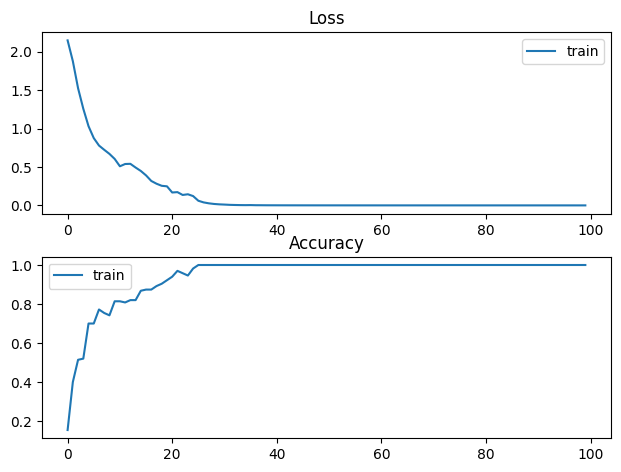

In [65]:
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
print('Train: %.3f' % (train_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.tight_layout(pad=1.0)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.legend()
plt.savefig('MediapipeAccuracyPlot.png')

# 3. Saving complete NN model

In [50]:
model.save('../export_data/PCA_nn_model.h5')

In [59]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1)))

2/2 [==============================] - 0s 5ms/step
Accuracy: 0.18518518518518517
